### import libraries

In [0]:
import numpy as np
import pandas as pd
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

### read train and test data

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

### text cleaning and pre-processing

In [0]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# pre-processing of text in 1 single function
def preprocess_text(text):
    # remove links from text - https
    non_http_list = [w for w in text.lower().split() if 'http' not in w]
    # remove @ words from tweets
    at_removed_list = [w for w in non_http_list if '@' not in w]
    # tokenize sentences to words
    words = word_tokenize(' '.join(at_removed_list))
    # remove punctuation
    word_list = [w for w in words if w not in string.punctuation]
    # remove stop words
    tokens = [w for w in word_list if w not in stop_words]
    # stemming
    stemmed = [porter.stem(w) for w in tokens]
    # lemmatization
    lemmatized = " ".join([lemmatizer.lemmatize(w) for w in tokens])
    
    return lemmatized

In [0]:
# preprocess and cleaned text stored in new column 'transformed_text'
train_df['transformed_text'] = train_df['text'].apply(lambda text: preprocess_text(text))
test_df['transformed_text'] = test_df['text'].apply(lambda text: preprocess_text(text))

# remove NaN values from keyword column
train_df['keyword'].fillna('', inplace=True)
test_df['keyword'].fillna('', inplace=True)

# # add non-null keyword values to tweet text
# train_df['transformed_text'] = train_df['transformed_text'] + ' ' + train_df['keyword']
# test_df['transformed_text'] = test_df['transformed_text'] + ' ' + test_df['keyword']
# train_df.head()

### EDA

Reference 1: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

#### pie chart for class distribution in training data

We see that the we don't have a class imbalance in the training dataset. The disaster and non-disaster tweets are pretty close to each other in terms of percentage.

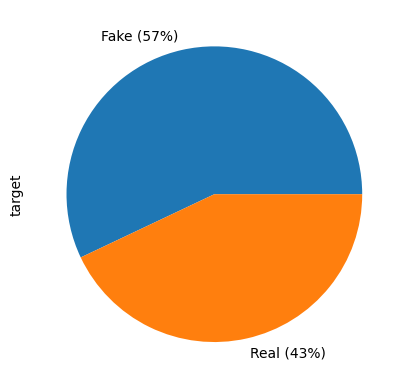

In [0]:
# import round

pos_no = round((train_df['target'].value_counts()/train_df['target'].value_counts().sum())*100)

train_df['target'].value_counts().plot(kind='pie', labels=['Fake ('+str(int(pos_no[0]))+'%)', 'Real ('+str(int(pos_no[1]))+'%)'])
plt.savefig('target_distribution_pie.png')

#### keyword and class distribution

We see that the there are some keywords where a majority of the tweets are clearly disaster tweets whereas for other keywords, a majority of tweets are non-disaster tweets. However, keywords where a lot of non-disaster tweets are there also relate a lot to disaster reporting and hence, it seems use of keyword for learning the class distribution won't be helpful.

In [0]:
import seaborn as sns

train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean')

plt.figure(figsize=(16, 72), dpi=300)

sns.countplot(y=train_df.sort_values(by='target_mean', ascending=False)['keyword'], 
    hue=train_df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
plt.savefig('keyword_class.png')
# plt.show()

train_df.drop(columns=['target_mean'], inplace=True)

#### bigram analysis

It seems that disaster tweets have a certain use of words that would relate to disasters but this is not entirely true. There are a lot of high frequency bigrams which don't really concern disaster. Also, non-disaster tweets have some bigrams such as 'burning building' or 'emergency services' which can relate to the occurrence of a disaster. This means that a rule-based system and just looking at presence of certain words wouldn't really help the model and also be not scalable.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


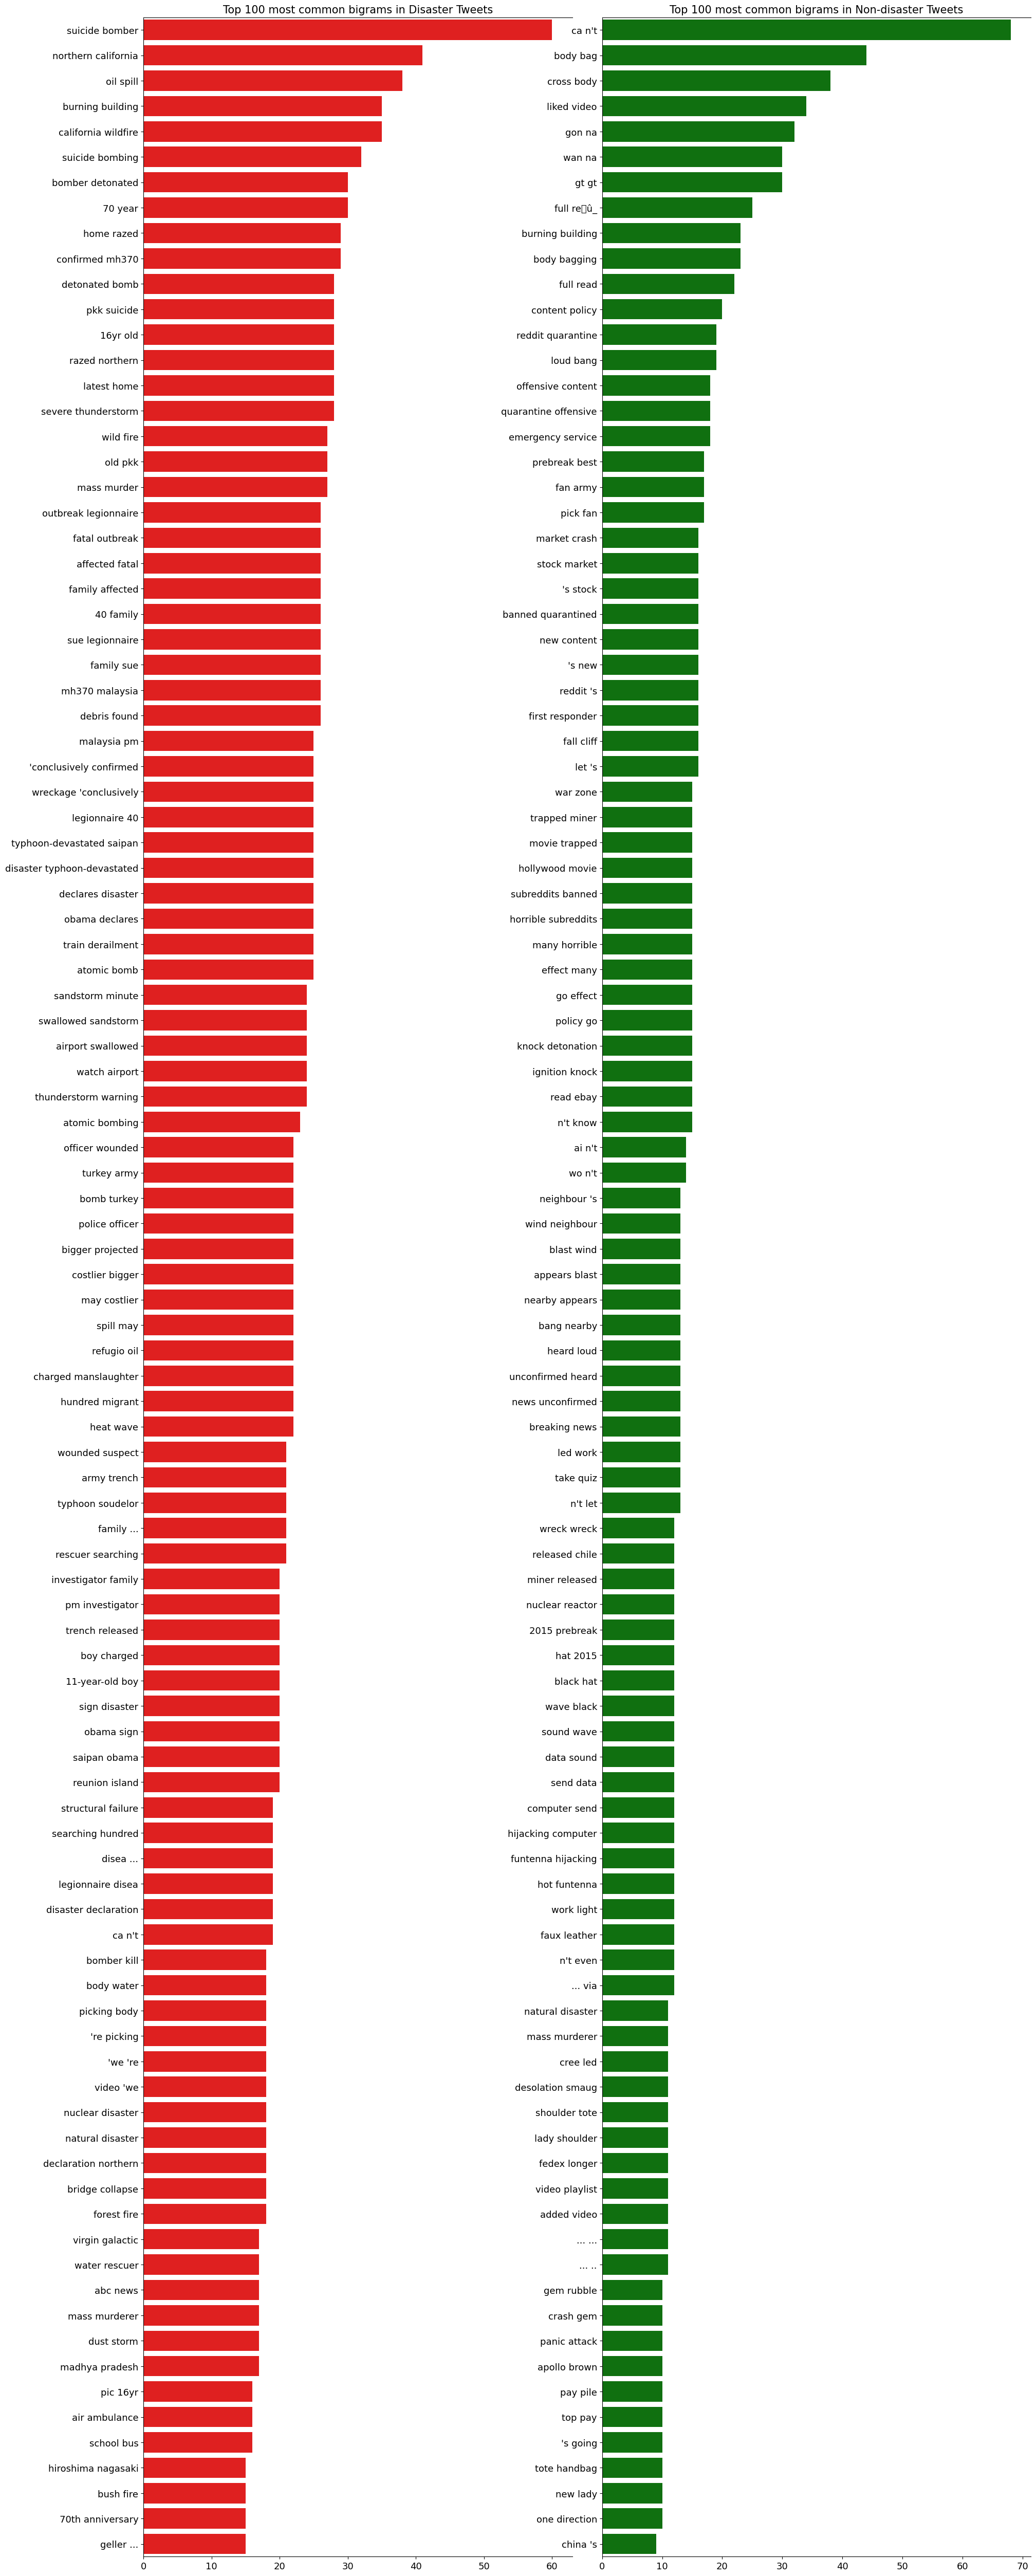

In [0]:
import seaborn as sns
from collections import defaultdict

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['transformed_text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['transformed_text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.savefig('bigram_analysis.png')
plt.show()

#### percentage of missing values for locations

In [0]:
train_missing = train_df.location.isnull().sum()
train_present = train_df.location.value_counts().sum()

test_missing = test_df.location.isnull().sum()
test_present = test_df.location.value_counts().sum()

print('Missing values in train: %d'%train_missing)
print('Present values in train: %d'%train_present)

print('Missing values in test: %d'%test_missing)
print('Present values in test: %d'%test_present)

Missing values in train: 2533
Present values in train: 5080
Missing values in test: 1105
Present values in test: 2158


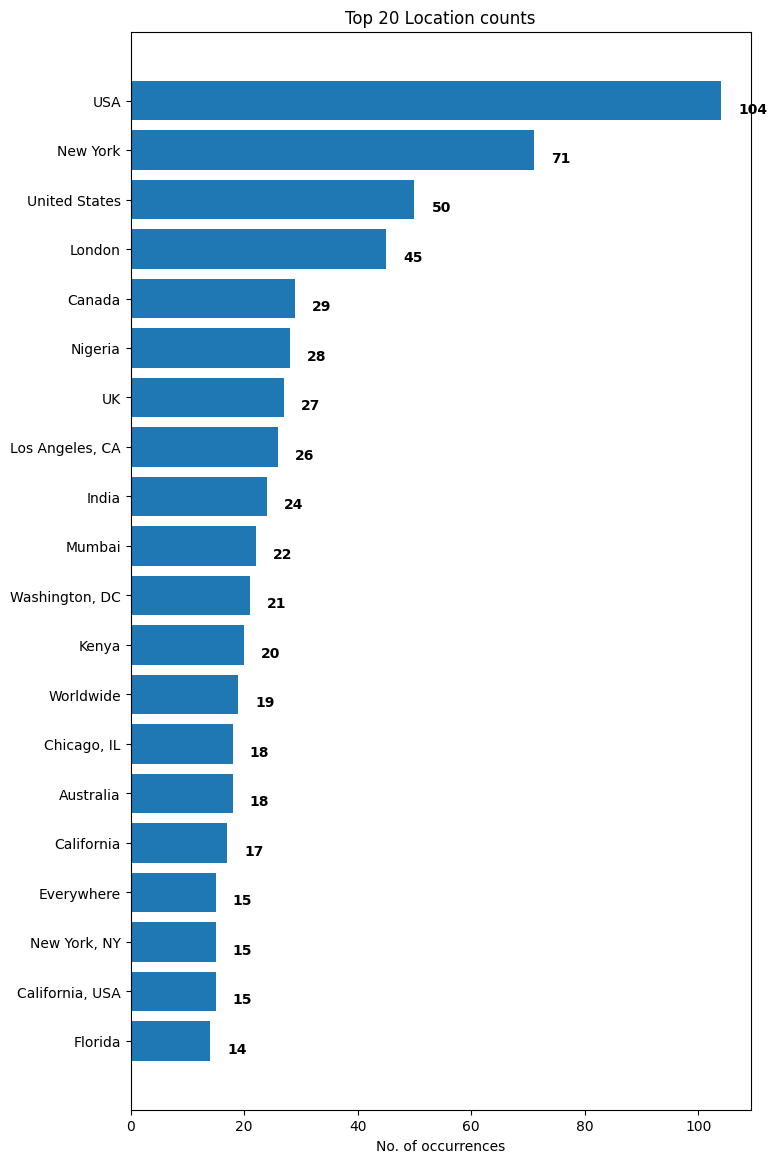

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(8,14)

x = train_df.location.value_counts().index.tolist()[:20]
y = train_df.location.value_counts().tolist()[:20]

y_pos = np.arange(len(x))
ax.barh(y_pos, y, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('No. of occurrences')
ax.set_title('Top 20 Location counts')

for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), fontweight='bold')

plt.savefig('location_discrete.png')
plt.show()

#### finding which keywords are frequent for top 10 locations (USELESS)

In [0]:
x = train_df.location.value_counts().index.tolist()[:25]
y = train_df.location.value_counts().tolist()[:25]

missing = train_df.location.isnull().sum()
present = train_df.location.value_counts().sum()

top_10_keywords = train_df.keyword.value_counts().index.tolist()[:10]
top_10_locations = train_df.location.value_counts().index.tolist()[:10]

print('keywords:')
print(top_10_keywords)
print('locations:')
print(top_10_locations)

all_locations = []
true_df = train_df[train_df['target']==1]
for loc in top_10_locations:
    filter_df = true_df[true_df['location'] == loc]
    all_locations.append(filter_df['keyword'].value_counts().index[0])

print(all_locations)
print('\n\n')
dict(zip(top_10_locations, all_locations)) 

keywords:
['fatalities', 'deluge', 'armageddon', 'harm', 'body%20bags', 'damage', 'sinking', 'evacuate', 'siren', 'collided']
locations:
['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria', 'UK', 'Los Angeles, CA', 'India', 'Mumbai']
['sandstorm', 'flood', 'hail', 'annihilated', 'oil%20spill', 'suicide%20bomb', 'bridge%20collapse', 'oil%20spill', 'derailment', 'wreckage']





{'Canada': 'oil%20spill',
 'India': 'derailment',
 'London': 'annihilated',
 'Los Angeles, CA': 'oil%20spill',
 'Mumbai': 'wreckage',
 'New York': 'flood',
 'Nigeria': 'suicide%20bomb',
 'UK': 'bridge%20collapse',
 'USA': 'sandstorm',
 'United States': 'hail'}

### CountVectorizer -  without using keyword column

In [0]:
# build bag of words model
countvec = feature_extraction.text.CountVectorizer()

# transform train, test data
train_vec = countvec.fit_transform(train_df['transformed_text'])
test_vec = countvec.transform(test_df['transformed_text'])

In [0]:
train_vec.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### TF-IDF vectorizer - without using keyword column

In [0]:
# build bag of words model
tfidfvec = feature_extraction.text.TfidfVectorizer()

# transform train, test data
train_vec = tfidfvec.fit_transform(train_df['transformed_text'])
test_vec = tfidfvec.transform(test_df['transformed_text'])

In [0]:
train_vec.shape

(7613, 13642)

### monte-carlo simulation for different classifiers

In [0]:
from sklearn.metrics import f1_score

def fit_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return f1_score(y_test, y_pred)

models = [LogisticRegression(), LinearSVC(), MultinomialNB(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=5), RandomForestClassifier()]
score_list = []
for model in models:
    score_list.append([])

loop = 5
for index in range(loop):
    x_train, x_test, y_train, y_test = train_test_split(train_vec, train_df['target'], test_size=0.2, shuffle=True, stratify=train_df['target'])
    for (i,model) in enumerate(models):
        score_list[i].append(fit_predict(model, x_train, y_train, x_test, y_test))

scores_final = np.array(score_list).mean(axis=1)
d = {'Classifier': ['Logistic Regression', 'Linear SVM', 'Multinomial Naive Bayes', 'Decision Tree', 'KNN', 'Random Forest'], 'Mean F-1 scores': scores_final}
models_f1_final = pd.DataFrame(d)
models_f1_final.to_csv('all_model_results.csv', index=False)
models_f1_final

,Classifier,Mean F-1 scores
0,Logistic Regression,0.738637
1,Linear SVM,0.741651
2,Multinomial Naive Bayes,0.742704
3,Decision Tree,0.695155
4,KNN,0.700837
5,Random Forest,0.720700


###### The results for the top 4 classifiers are close hence we do hyper-parameter tuning for all of them 

### Hyper-parameter tuning for Logistic Regression

In [0]:
# define classifiers
logreg = LogisticRegression(max_iter=10000)
parameters = {'C':[0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
clf = GridSearchCV(logreg, parameters, cv=10, scoring='f1')

# fit classifier to training data
clf.fit(train_vec, train_df['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

# predict labels for test data
predictions = clf.predict(test_vec)
test_df['target'] = predictions

# generate submission csv file
# test_df[['id','target']].to_csv('submission.csv',index=False)

Best score: 0.561651

Best params: {'C': 10, 'solver': 'newton-cg'}


### Hyper-parameter tuning for Linear SVM

In [0]:
# define classifiers
# clf = linear_model.RidgeClassifier()
# clf = LogisticRegression(solver='lbfgs')
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svc = LinearSVC(max_iter=10000)
clf = GridSearchCV(svc, parameters, cv=10)

# # f-1 score for all k-fold runs
# scores = model_selection.cross_val_score(clf, x_train, train_df["target"], cv=10, scoring='f1')
# print(scores)
# print(scores.mean())

# fit classifier to training data
clf.fit(train_vec, train_df['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))
# print('\nBest no.of cv splits:%d'%clf.n_splits_)
# print('\nCV results dict:\n')
# print(clf.cv_results_)

# # predict labels for test data
# predictions = clf.predict(test_vec)
# test_df['target'] = predictions

# # generate submission csv file
# test_df[['id','target']].to_csv('submission.csv',index=False)

# # create a dataframe of mean scores for each value of C - Linear SVM
# d = {'C': parameters['C'], 'mean test score': clf.cv_results_['mean_test_score'].tolist()}
# df = pd.DataFrame(d)
# df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score: 0.693811

Best params: {'C': 0.1}


### Hyper-parameter tuning for Multinomial Naive Bayes

In [0]:
parameters = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
mnb = MultinomialNB()
clf = GridSearchCV(mnb, parameters, cv=10)

# fit classifier to training data
clf.fit(train_vec, train_df['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

predictions = clf.predict(test_vec)
test_df['target'] = predictions

# generate submission csv file
test_df[['id','target']].to_csv('submission.csv',index=False)

Best score: 0.702093

Best params: {'alpha': 1}


### Hyper-parameter tuning for Decision Tree

In [0]:
parameters = {'criterion': ['gini', 'entropy']}
mnb = DecisionTreeClassifier()
clf = GridSearchCV(mnb, parameters, cv=10)

# fit classifier to training data
clf.fit(train_vec, train_df['target'])

print('Best score: %f'%clf.best_score_)
print('\nBest params: '+str(clf.best_params_))

Best score: 0.535922

Best params: {'criterion': 'entropy'}
